## setup and notebook configuration

In [1]:
import numpy as np

In [2]:
# matplotlib, plotting setup
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns                       # nice plotting defaults
import cmocean as cmo                       # ocean colormaps
sns.set()
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML
#%config InlineBackend.figure_format = 'svg'

/Users/corbin/virtual_envs/FEMexperiment_env/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# local imports
import src.fem_base.master.master_1D as M1D
import src.handlers.dof_handler_1D as DOFH
import src.msh.mesh_1D as MSH
import src.fem_maps.fem_map as MAP

# problem statement

We consider the linear scalar wave equation

\begin{align}
    \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0, \qquad x\in\Omega
\end{align}

where we choose a linear flux $f(u) = au$ for some $a$.

# semi-discrete scheme

Considering the "weak" DG-FEM form,  we have the semi-discrete element local equation

\begin{align}
    \int_K \frac{\partial u_h}{\partial t} v \, dK
    -\int_{K} (au_h) \frac{\partial v}{\partial x} \, dK = 
    -\int_{\partial K} \hat{n}\cdot \widehat{au} v \, d\partial K
\end{align}

Choosing a representation $u=u_i\phi_i$ piecewise polynomial over each element, and the same test space, we have, for a given choice of numerical flux $\widehat{au}$, and noting that in 1D, the normal vectors on the element interior are are simply $n^- =(-1, +1)$:

\begin{align}
    \int_K \frac{\partial}{\partial t} (u_i(t) \phi_i(x)) \phi_j(x) \, dx
    -\int_{K} a(u_i(t)\phi_i(x)) \frac{\partial \phi_j(x)}{\partial x} \, dx = 
    -( \hat{n}^-(x_R)\widehat{au}(x_R) + \hat{n}^-(x_L)\widehat{au}(x_L))
\end{align}

transforming the integrals to the reference element:

\begin{align}
    \int_{\hat{K}} \frac{\partial}{\partial t} (u_i(t) \phi_i(\xi)) \phi_j(\xi) \,|det(J)|\, d\xi
    -\int_{\hat{K}} a(u_i(t)\phi_i(\xi)) \frac{\partial \phi_j(\xi)}{\partial \xi} \, |det(J)|\, d\xi = 
    -((+1)\widehat{au}(x_R) + (-1) \widehat{au}(x_L))
\end{align}

This completes the description of the semi-discrete scheme, and we have a choice as to how to compute these integrals. The important part is that since the coefficients $u_i$ vary in time but are constants with respect to space, we can write 

\begin{align}
    &\frac{\partial u_i(t)}{\partial t} \int_{\hat{K}} \phi_i(\xi) \phi_j(\xi) \,|det(J)|\, d\xi
   -au_i\int_{\hat{K}} \phi_i(\xi) \left(\frac{d\xi}{dx}\right)\frac{\partial \phi_j(\xi)}{\partial \xi} \, |det(J)|\, d\xi = 
    -(\widehat{au}(x_R) - \widehat{au}(x_L)) \\
   &\Rightarrow M_K \vec{\frac{du_h}{dt}} - a  S_K \vec{u_h} 
   = - L\, (\widehat{au}(x_R) -\widehat{au}(x_L))
\end{align}

Where we have computed $M_K$ and $S_K$, the mass and stiffness matrices for element $K$. Although we would normally do this with a quadrature rule, we can take advantage of the fact that in 1D (and indeed under any affine mapping from reference to physical element), $J^{-1}$ and $|\det(J)|$ will be constant over the entire element (also note that in 1D, $J^{-1}$ is a 1x1 matrix)<sup>1</sup>. In that case, we can treat both as constants, precompute $M_{\hat{K}}, S_{\hat{K}}$, and multiply the entire element-local equation by $M^{-1}$, giving

\begin{align}
\vec{\frac{du_h}{dt}} &=  a \frac{\det(J)_K}{\det(J)_K}\, J^{-1}_K M_{\hat{K}}^{-1}S^T_{\hat{K}} \vec{u_h} 
  - \frac{1}{\det(J)_K} M^{-1}_K L\, (\widehat{au}(x_R) - \widehat{au}(x_L)) \\
  &=  a \, J^{-1}_K M_{\hat{K}}^{-1}S^T_{\hat{K}} \vec{u_h} 
  - \frac{1}{\det(J)_K} M^{-1}_K L\, (\widehat{au}(x_R) - \widehat{au}(x_L))
\end{align}

Which is a good form for a black box integrator, since we have a "naked" $\frac{du_h}{dt}$, and because the scheme is explicit.

note<sup>1</sup>: $J, J^{-1}$ are 1x1 matrices, and $\det{J}$ is simply $J_{11}$; $J^{-1} = 1/J_{11}$. It's important for the clarity of explicit schemes to understand where these cancellations occur.

There is a final question as to how to impose boundary conditions. At the inflow boundary, we impose it directly in a dirichlet sense. At the outflow boundary, Hesthaven uses strong form, which says [TODO], which is equivalent to equating the numerical flux to the $u^-(x_R)$ of the boundary element. 

# numeric implementation

## problem setup

In [5]:
# global constants
π = np.pi

setting the spatial discretization amounts to declaring the appropriate mesh, finite element map, and choosing an local polynomial order of the finite element approximation.

In [6]:
p = 1
n_elm = 12
mesh = MSH.Mesh1D(P=np.linspace(0, 2*π, n_elm+1))
master = M1D.Master1D(p=p)
dofh = DOFH.DG_DOFHandler1D(mesh, master)

# temporary adapter to mesh
mapdgn = np.zeros((dofh.dgnodes.shape[0], 1, dofh.dgnodes.shape[1]))
mapdgn[:,0,:] = dofh.dgnodes
_map = MAP.Isoparametric_Mapping(master=[master], dgnodes=[mapdgn], map_nodes='NODAL')

Some basic visualization for our 1D solution

In [7]:
plot_master = M1D.Master1D(p=20, node_spacing='EQUIDISTANT')
plot_nodes = plot_master.nodal_pts
plot_shap = master.basis.shape_functions_at_pts(plot_nodes)
    
def plot_solution(ax, u, dofh, plot_shap=None):
    """ u formatted like dgnodes """
    for elm in range(dofh.nElm):
        nodal_pts = dofh.dgnodes[:, elm]
        nodal_values = u[:, elm]
        if plot_shap is not None:
            plot_pts = np.dot(plot_shap, nodal_pts)
            nodal_values = np.dot(plot_shap, nodal_values)
            ax.plot(plot_pts, nodal_values)
        else:
            ax.plot(nodal_pts, nodal_values)
    return ax

## sanity check: spatial derivative operators

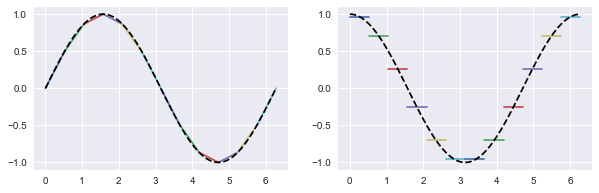

In [8]:
u0 = np.sin(dofh.dgnodes)
xx = np.linspace(0, 2*π, 100)
fig = plt.figure(figsize=(10,3))

ax = fig.add_subplot(1, 2, 1)
ax = plot_solution(ax, u0, dofh, plot_shap=plot_shap)
ax.plot(xx, np.sin(xx - 2*π*0), 'k--')

ax = fig.add_subplot(1, 2, 2)
dudx =  np.dot(1./_map._detJ[0][0,0]*master.Minv, np.dot(master.S, u0))
ax = plot_solution(ax, dudx, dofh)
ax.plot(xx, np.cos(xx - 2*π*0), 'k--')
plt.show()

## computation of fluxes

Declare a modular function which can compute the flux. This represents an implementation of the flux above, where $\alpha=0$ corresponds to an upwind flux and $\alpha=1$ corresponds to a central flux.

In [9]:
def compute_interior_flux(u, norm, dofh, a, α):
    """ computes the numerical flux at all of the element interfaces
    @param u  the current solution u, dgnodes form
    NOTE: boundary interfaces will be filled with garbage, and must be corrected
    """
    pm = dofh.lg_PM
    ur = u.ravel(order='F')
    nr = norm.ravel(order='F')
    
    # equivalent to the flux
    #  \hat{au} = {{au}} + (1-α) * |a|/2 * [[u]]
    # at element interfaces. First and last interface will have garbage.
    flux = a/2*(ur[pm['-']] + ur[pm['+']]) + (1-α)*np.abs(a)/2.*nr*(ur[pm['-']] - ur[pm['+']] )
    flux = flux.reshape(norm.shape, order='F')
    return flux

In [10]:
def advect_rhs_1D(u, t, a, master, _map, dofh, flux_fn, gD, normals, α=0):
    
    Minv, S, L = master.Minv, master.S, master.L
    Jinv = _map.Jinv[0][:,0,0,:]
    detJ = _map._detJ[0]

    # interior fluxes
    elm_edge_flux = flux_fn(u, normals, dofh, a, α=α)

    # compute boundary fluxes
    elm_edge_flux[0, 0] = a*gD(t)
    ur = u.ravel(order='F')
    pm = dofh.lg_PM
    elm_edge_flux[-1, -1] = a*ur[pm['-']][-1] 
    elm_edge_flux *= normals

    # don't need to scale faces
    edge_int = -1./detJ * np.dot(Minv, np.dot(L, elm_edge_flux))
    int_int = a * Jinv * np.dot(Minv, np.dot(S.T, u))
    RHS = int_int + edge_int
    return RHS

Exact solution $u = \sin(x - 2\pi t)$ implies that $\frac{d}{dx}(au) = a\frac{du}{dx} = a\cos(x - 2\pi t)$, so we can check the interior contribution.

Check that the discrete derivative operator $Dr = M^{-1} S$ is correctly transforming the exact solution to its derivative, represented one polynomial order lower than that of the polynomial solution space.

## time-marching: forward Euler

The following setup will need to be done for every run of the advection problem

In [11]:
# final time, advection speed
T = 2*π
a = 2*π

# compute time step size, irrelevant for backward euler
CFL = 0.75
Δx = dofh.dgnodes[1,0] - dofh.dgnodes[0,0]
Δt = CFL/(2*π)*Δx
Δt = Δt / 2

# number of timesteps needed
steps = int(np.ceil(T/Δt))
times = np.linspace(0, T, steps)
Δt = times[1] - times[0]

In [12]:
# initial condition
FwdE_solution = np.zeros((steps+1, *dofh.dgnodes.shape))
FwdE_solution[0,::] = np.sin(dofh.dgnodes)

t = 0
gD = lambda t: np.sin(-a*t)

In [13]:
# normal vectors, all positive
norm = np.ones((2, dofh.nElm))
norm[0,:] *= -1

# function pointer to something that can compute fluxes
flux_fn = compute_interior_flux

In [14]:
# simple time loop
for tstep in range(steps):
    u = np.copy(FwdE_solution[tstep, ::])
    t = times[tstep]
    rhsu = advect_rhs_1D(u, t, a, master, _map, dofh, flux_fn, gD, norm)
    u += Δt * rhsu
    
    # update time step
    FwdE_solution[tstep+1, :,:] = u

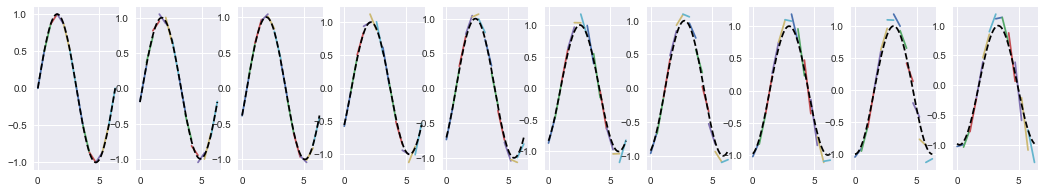

In [15]:
Nplots = 10
xx = np.linspace(0, 2*π, 100)

times = np.linspace(0, T, steps)
assert np.isclose(times[1]-times[0], Δt)

fig = plt.figure(figsize=(18,3))
for i in range(Nplots):
    u = FwdE_solution[i,:,:]
    ax = fig.add_subplot(1, Nplots, i+1)
    ax = plot_solution(ax, u, dofh)
    ax.plot(xx, np.sin(xx - 2*π*times[i]), 'k--')

much better is if we can animate the solution

In [16]:
# animate solution
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
xx = np.linspace(0, 2*π, 100)

def _init():
    ax.set_xlim((0, 2*π))
    ax.set_ylim((-1, 1))
    return line,

def update_FE(i):
    ax.clear()
    ax.set_xlim((0, 2*π))
    ax.set_ylim((-1.5, 1.5))
    plot_solution(ax, FwdE_solution[i,:,:], dofh, plot_shap=plot_shap)
    ax.plot(xx, np.sin(xx - 2*π*times[i]), 'k--', lw=1)
    return (line,)

FEanim = animation.FuncAnimation(fig, update_FE, init_func=_init, frames=steps,
                               interval=75 , repeat=False, blit=True)
plt.close()

In [17]:
FEmovie = FEanim.to_html5_video()
HTML(FEmovie)

This is suspect, because we should have that the energy norm is not growing, as long as we are within CFL.

## time marching: fourth-order LSERK

In [18]:
# Low storage Runge-Kutta coefficients LSERK
rk4a = np.array([
         0.0,
        -567301805773.0/1357537059087.0,
        -2404267990393.0/2016746695238.0,
        -3550918686646.0/2091501179385.0,
        -1275806237668.0/842570457699.0])

rk4b = np.array([ 
         1432997174477.0/9575080441755.0,
         5161836677717.0/13612068292357.0,
         1720146321549.0/2090206949498.0,
         3134564353537.0/4481467310338.0,
         2277821191437.0/14882151754819.0])

rk4c = np.array([
         0.0,
         1432997174477.0/9575080441755.0,
         2526269341429.0/6820363962896.0,
         2006345519317.0/3224310063776.0,
         2802321613138.0/2924317926251.0])


In [19]:
RK_resid = np.zeros_like(dofh.dgnodes)
LSERK_stages = [0, 1, 2, 3, 4]

# initial condition, advection speed
LSERK_solution = np.zeros((steps+1, *dofh.dgnodes.shape))
LSERK_solution[0,::] = np.sin(dofh.dgnodes)

# time loop
t=0
for tstep in range(steps):
    u = np.copy(LSERK_solution[tstep, ::])
    RK_resid = np.zeros_like(dofh.dgnodes)
    for s in LSERK_stages:
        t_local = t + rk4c[s]*Δt
        rhsu = advect_rhs_1D(u, t_local, a, master, _map, dofh, flux_fn, gD, norm, α=0)
        RK_resid = rk4a[s]*RK_resid + Δt*rhsu
        u += rk4b[s]*RK_resid
    t += Δt
    LSERK_solution[tstep+1, :,:] = u

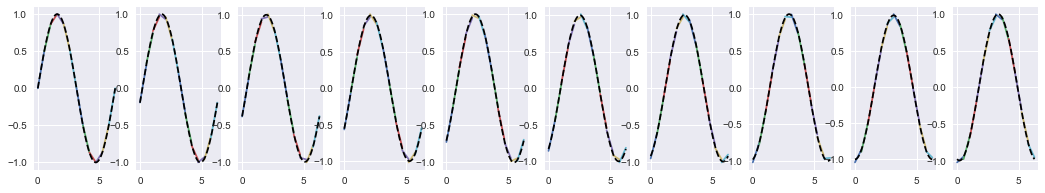

In [20]:
Nplots = 10
xx = np.linspace(0, 2*π, 100)

times = np.linspace(0, T, steps)
assert np.isclose(times[1]-times[0], Δt)

fig = plt.figure(figsize=(18,3))
for i in range(Nplots):
    u = LSERK_solution[i,:,:]
    ax = fig.add_subplot(1, Nplots, i+1)
    ax = plot_solution(ax, u, dofh)
    ax.plot(xx, np.sin(xx - 2*π*times[i]), 'k--')

In [21]:
# animate solution
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
xx = np.linspace(0, 2*π, 100)

def update_LSERK(i):
    ax.clear()
    ax.set_xlim((0, 2*π))
    ax.set_ylim((-1.5, 1.5))
    plot_solution(ax, LSERK_solution[i,:,:], dofh, plot_shap=plot_shap)
    ax.plot(xx, np.sin(xx - 2*π*times[i]), 'k--', lw=1)
    return (line,)

LSERKanim = animation.FuncAnimation(fig, update_LSERK, init_func=_init, frames=steps,
                               interval=75 , repeat=False, blit=True)
plt.close()

In [22]:
LSERKmovie = LSERKanim.to_html5_video()
HTML(LSERKmovie)

This result seems to match Hesthaven.

## time marching: `SciPy` library

TODO

# analysis and convergence

## energy considerations

## spatial convergence study

Using a fourth-order Runge Kutta scheme should be sufficient to ensure that spatial, rather than temporal error dominates. We perform a small convergence study to see if we can match Hesthaven's results. We modify the test case above, measuring the $L^2$ global errors at time $t=T=\pi$.

In [30]:
import src.fem_base.compute_errors as ERRORS
L2Error = ERRORS.L2_error_1D_domain

In [31]:
def problem_discretization(p, n_elm):
    mesh = MSH.Mesh1D(P=np.linspace(0, 2*π, n_elm+1))
    master = M1D.Master1D(p=p)
    dofh = DOFH.DG_DOFHandler1D(mesh, master)

    # temporary adapter to mesh
    mapdgn = np.zeros((dofh.dgnodes.shape[0], 1, dofh.dgnodes.shape[1]))
    mapdgn[:,0,:] = dofh.dgnodes
    _map = MAP.Isoparametric_Mapping(master=[master], dgnodes=[mapdgn], map_nodes='NODAL')
    return mesh, master, dofh, _map

In [32]:
# final time, advection speed
T = π
a = 2*π

# function pointer to something that can compute fluxes
flux_fn = compute_interior_flux

In [33]:
def linear_advection_run(mesh, master, dofh, _map, measure_steps=None):
    # compute time step size, irrelevant for backward euler
    CFL = 0.75
    Δx = dofh.dgnodes[1,0] - dofh.dgnodes[0,0]
    Δt = CFL/(2*π)*Δx
    Δt = Δt / 10

    # number of timesteps needed
    steps = int(np.ceil(T/Δt))
    times = np.linspace(0, T, steps)
    Δt = times[1] - times[0]
    
    # normal vectors, all positive
    norm = np.ones((2, dofh.nElm))
    norm[0,:] *= -1

    RK_resid = np.zeros_like(dofh.dgnodes)
    LSERK_stages = [0, 1, 2, 3, 4]

    # initial condition, advection speed
    LSERK_solution = np.zeros((steps+1, *dofh.dgnodes.shape))
    LSERK_solution[0,::] = np.sin(dofh.dgnodes)

    # time loop
    t=0
    for tstep in range(measure_steps+1):
        u = np.copy(LSERK_solution[tstep, ::])
        RK_resid = np.zeros_like(dofh.dgnodes)
        for s in LSERK_stages:
            t_local = t + rk4c[s]*Δt
            rhsu = advect_rhs_1D(u, t_local, a, master, _map, dofh, flux_fn, gD, norm, α=0)
            RK_resid = rk4a[s]*RK_resid + Δt*rhsu
            u += rk4b[s]*RK_resid
        t += Δt
        LSERK_solution[tstep+1, :,:] = u
    return LSERK_solution, times

We have to make sure that the timesteps are small enough such that we can accurately measure the spatial error. Simultaneously, we want to stay in CFL and test fast enough that the convergence study can be converted to a unit test. 

If we use a normal timestep within CFL, temporal errors will pollute the convergence rate. If we use a small enough timestep such that spatial error dominates, then doing the runs out to $T$ becomes very expensive.

The tradeoff is that we only integrate a few timesteps and measure against the exact solution.

In [34]:
# convergence study
N = [1, 2, 3, 4, 5, 6, 7, 8]
K = [2, 4, 8, 16, 32, 64]

measure_step = 10
run_data = dict()
for p in N:
    L2_errors = []
    for n_elm in K:
        setup = problem_discretization(p, n_elm)
        solution, times = linear_advection_run(*setup, measure_steps=measure_step)
        measure_time = times[measure_step]
        u_exact = lambda x: np.sin(x - 2*π*measure_time)
        L2_errors.append(L2Error(solution[measure_step,::], u_exact,
                        dofh=setup[2], _map=setup[3], master=setup[1]))
    run_data[p] = L2_errors

compute convergence rate

\begin{align}
    ||u_{k+1} - u^* || &= C\, ||h_{k+1}||\,^p \\
    ||u_{k} - u^* ||  &= C\, ||h_{k}||\,^p \\
    \log\left(\frac{e^{k+1}}{e^k}\right) &= p\log\left(\frac{h^{k+1}}{h^k}\right)
    \Rightarrow p = \frac{\log\left(\frac{e^{k+1}}{e^k}\right) }{\log\left(\frac{h^{k+1}}{h^k}\right)}
\end{align}

In [35]:
# convergence table
print('{}'.format(70*'-'))
print("{}{:5d}{:9d}{:9d}{:9d}{:9d}{:9d}{:>12}".format("p\K", 2, 4, 8, 16, 32, 64, 'rate'))
print('{}'.format(70*'-'))
for p in N:
    errs = run_data[p]
    datastr = " ".join(['{:.2e}'.format(err) for err in errs])
    hs = [2*π/k for k in K]
    rate = np.log(errs[2]/errs[1]) / np.log(hs[2]/hs[1])
    datastr += "{:5}{:.2f}".format(' ', rate)
    print("{}  {}".format(p, datastr))
print('{}'.format(70*'-'))

----------------------------------------------------------------------
p\K    2        4        8       16       32       64        rate
----------------------------------------------------------------------
1  1.65e+00 3.41e-01 8.78e-02 2.24e-02 5.62e-03 1.41e-03     1.96
2  3.40e-01 6.46e-02 8.54e-03 1.08e-03 1.35e-04 1.69e-05     2.92
3  1.04e-01 5.20e-03 3.31e-04 2.07e-05 1.30e-06 8.10e-08     3.97
4  4.27e-03 3.80e-04 1.22e-05 3.84e-07 1.20e-08 3.76e-10     4.96
5  1.85e-03 2.17e-05 3.43e-07 5.37e-09 8.39e-11 1.30e-12     5.99
6  3.24e-05 1.11e-06 8.89e-09 7.00e-11 5.61e-13 8.22e-15     6.97
7  1.69e-05 4.90e-08 1.92e-10 7.84e-13 2.36e-14 3.19e-15     7.99
8  1.74e-07 1.97e-09 3.88e-12 9.66e-14 8.67e-15 1.21e-15     8.99
----------------------------------------------------------------------


And we recover the expected convergence rates of $p+1$. We indicate the region of aymptotic convergence in which we are measuring

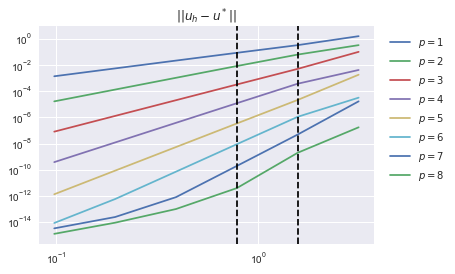

In [36]:
# convergence plots, with region of asymptotic convergence
fig, ax = plt.subplots()
for p in N:
    hs = [2*π/k for k in K]
    errs = run_data[p]
    ax.loglog(hs, errs, label=r'$p={}$'.format(p))
ax.axvline(hs[1], linestyle='--', c='k')
ax.axvline(hs[2], linestyle='--', c='k')
ax.legend(bbox_to_anchor=(1.02, 1))
ax.set_title(r'$||u_h - u^*||$')
plt.show()

# TODO

- 1D viz pulled into library code
- scipy black box time integration implemented
- unit test based on convergence of results